For our $2\omega + 3\omega$ experiment, 

<span style="color:orangered"> $\forall l \in \mathbb{Z}, \quad \displaystyle \sum_{\substack{n, m \in \mathbb{Z}^{2}\\ 2n + 3m = l}} J_n\left(\alpha \right)J_m\left(\beta \right)e^{-i \left( n\varphi_1 + m \varphi_2\right)}$</span>

# Shapiro for PM experiment 1 : Emission at 0 DC

So here the idea is to set the junction @ 0 voltage, and then to look @ the emitted spectrum. 

The I-V characteristic is, as per the multiharmonic notebook : 

$I = I_0 \displaystyle \sum_{l\in \mathbb{Z}} \left| p_l \right| \sin\left(\theta_0 + \omega_J t + l\omega t + \mathrm{Arg}(p_l)\right)$.

Since $V = 0$, $\omega_J = 0$ and thus :

$I = I_0 \displaystyle \sum_{l\in \mathbb{Z}} \left| p_l \right| \sin\left(\theta_0 + l\omega t + \mathrm{Arg}(p_l)\right)$.

So looking at the components of the signal having frequency $\omega$ :

$I_\omega = I_0 \Big(\left|p_{-1}\right|\sin\big(\theta_0 - \omega t + \mathrm{Arg}\left(p_{-1}\right)\big) + \left|p_{1}\right|\sin\big(\theta_0 + \omega t + \mathrm{Arg}\left(p_{1}\right)\big) \Big)$

Note : since we are forcing $V_{DC} = 0$ and $I_{DC} = 0$, the DC term $I_{DC} = I_0 \left|p_0 \right| \sin\left(\theta_0 + \mathrm{Arg}\!\left(p_0\right) \right)$ means that <span style='color:royalblue'> $\theta_0 = -\mathrm{Arg}\!\left(p_0\right) + n\pi$ </span> so long as $\left| p_0 \right| \neq 0$


When disspiating through a resistance R, this gives a power of :

<span style="color:royalblue">$P_\omega = \frac{R I_0^2}{2}\Big( \left| p_{-1} \right| ^2 + \left| p_{1} \right| ^2 + 2\left|p_{-1} \right| \left|p_{1} \right| \cos \left( 2\theta_0 + \mathrm{Arg}\!\left( p_1\right) + \mathrm{Arg}\!\left( p_{-1}\right) \right) \Big)$</span>



#### But what does the VNA display ? (Çağlar please don't kill me if I switched up the I and Q components)

VNA gets its transmission by calculating $I = \left\langle V_{p}(t)\cdot \sin(\omega t)\right\rangle_{\omega}$ and $Q = \left\langle V_{p}(t)\cdot -\cos(\omega t)\right\rangle_{\omega}$. (usually we write the in-phase component by mupltiplying by $\cos$ and the quadrature one by multiplying by $\sin$, but since here it's easier to have $\sin$ as the in-phase component, the quadrature component becomes <span style='color:orangered'> $-\cos$ </span>).

Then, since : 

$\sin(\theta_0 + l\omega t + \mathrm{Arg}(p_l))\sin(\omega t) = \frac{1}{2}\left( \cos(\theta_0 + (l - 1)\omega t + \mathrm{Arg}(p_l)) \right) - \cos(\theta_0 + (l + 1)\omega t + \mathrm{Arg} (p_l))$

And : 

$\sin(\theta_0 + l\omega t + \mathrm{Arg}(p_l))\cos(\omega t) = \frac{1}{2}\left( \sin(\theta_0 + (l - 1)\omega t + \mathrm{Arg}(p_l)) \right) + \sin(\theta_0 + (l + 1)\omega t + \mathrm{Arg} (p_l))$,

we get (the time-averaging by the VNA keeps only the terms in the sum that have no time dependance, ie $\pm 1$):

\begin{equation*}
\begin{cases}
I &= \frac{1}{2}\Big( \left|p_1 \right|\cos(\mathrm{Arg}(p_1)) - \left|p_{-1} \right|\cos(\mathrm{Arg}(p_{-1}))  \Big)\\
Q &= \frac{1}{2}\Big( -\left|p_1 \right|\sin(\mathrm{Arg}(p_1)) - \left|p_{-1} \right|\sin(\mathrm{Arg}(p_{-1}))  \Big)\\
\end{cases}
\end{equation*}

such that :


\begin{equation}
    S = I + i\cdot Q = \frac{1}{2} \Big( \overline{p_{1}} - p_{-1}\Big)
\end{equation}

## Let's try and do some predictions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv
from scipy.signal import convolve

In [2]:
# --- Just a helper function 

def make_centered_l_indices(n):
    if n % 2 == 0:
        raise ValueError(
            "array to make l values from has an even number of elements.")
    else:
        x = (n - 1) // 2
        return np.arange(-x, x + 1)

# --- Coefficients for an arbitrary sum of harmonics
def pl(alphas, phis, convolution_harmonics=10, max_l=None):
    """
    V2 : Making the function iterative instead of recursive.
    Gabelli's 'Shaping a time-dependent excitation
    to control the electron distribution function:
    noise minimization in a tunnel junction' gives
    the idea for 2 harmonics, ask Christian Glattli
    if you don't get it.
    Computes the pl coefficients (complex, Pl = pl*np.conjugate(pl)).
    With TF the fourier transform operation, and o the convolution
    product :
    TF(signal1*signal2*...*signaln) = TF(signal1*...*signaln-1) o TF(signaln)
    and so on
    thus this calculation.
    Parameters
    ----------
    alphas : list of floats
        list of RF harmonics amplitudes in units of alpha.
    phis : list of floats
        list of RF harmonics phases in rads
    Keyword arguments
    ----------
    convolution_harmonics : int
        number of harmonics to include for each multiple of f when computing the convolutions.
    max_l : 10
        max index of l with which we take the Pl.
    Returns
    -------
    numpy array of complex numbers:
        values of the pl, ordered from -max_l to +max_l.
    """

    if len(alphas) != len(phis):
        raise ValueError("Alphas and phis must have same length")
    elif max_l is None:
        max_l = convolution_harmonics
    elif max_l > convolution_harmonics:
        raise ValueError(
            "Due to nature of convolution, taking max_l > convolution_harmonics will lead to wrong results."
        )

    highest_RF_harmonic_number = len(alphas)  # there ar as many elements in alphas as there are RF harmonics.

    # just a shorthand : renaming this value to q. this isn't very fun with computer memory but whatever, I want this code to be as clear as possible.
    q = highest_RF_harmonic_number

    # this is the minimum number of l values (ie : harmonics due to the contribution of a sigular RF frequency) to appear in each harmonic's Pl during the convolution.
    p = convolution_harmonics

    frequency_array_length = (
        2 * p * q + 1
    )  # we have to have 2pq+1 points for there to be enough values of + and - l for the highest RF frequency.

    pl_values_untruncated = np.zeros(
        (frequency_array_length), dtype=np.clongdouble
    )  # initializing the array that will contain the pl.
    pl_values_untruncated[p * q] = (
        1 + 0j
    )  # setting the center value of the original array makes it a discrete Dirac delta, the neutral element wrt convolution.
    # choosing this means that we don't have to treat the first harmonic differently from the others, which should help with debugging and avoid weird behaviours.

    for harmonic_index, harmonic_alpha in enumerate(alphas):
        # getting this RF harmonic's phase.
        harmonic_phi = phis[harmonic_index]

        n = (
            harmonic_index + 1
        )  # the actual number of the RF harmonic, ie what multiple of f it is.

        pl_values_harmonic = np.zeros(
            (frequency_array_length), dtype=np.clongdouble
        )  # initializing the pl array for this harmonic, which we'll convolve with the overall array soon.

        i_0 = (
            p * q % n
        )  # offset to use so that we always reach the center point when taking harmonics every whatever point.
        # that's because the pl of the nth harmonic are spaced by n times more than the base harmonic, but they stay centered on the center (DC) harmonic.

        number_nonzero_harmonics = (frequency_array_length - 2 * i_0 - 1) // n + 1  # those are the only points of the FT of this RF harmonic's contribution which get nonzero_values

        l_indices = make_centered_l_indices(number_nonzero_harmonics)  # creating the centered l indicies for this number of values.

        pl_phases = np.exp(
            -1j * harmonic_phi * l_indices
        )  # generates the list of all complex phase shifts for this RF harmonic's pl.
        pl_moduli = jv(
            l_indices, harmonic_alpha
        )  # and now we're generating the moduli. Just need to multiply these tpgether to get the whole set of pl.
        pl_moduli = np.array(pl_moduli, dtype=np.clongdouble)

        # print(pl_phases)

        pl_values_harmonic[i_0::n] = (
            pl_moduli * pl_phases
        )  # setting relevant values of the pl, with adequate spacing, as discussed above.

        pl_values_untruncated = convolve(
            pl_values_untruncated, pl_values_harmonic, "same"
        )  # run the actual convolution.
        # This updates pl_values_untruncated successively by adding the harmonics one after the other.
        # I use 'same' so that the resulting array doesn't get unnecessarily big and bloated with zero-padding. We don't lose any data doing this, we just bypass the zero-padding.

    # Now, we only need to truncate the resulting array.

    truncation_index = p * q - max_l
    if truncation_index == 0:
        # when slicing, the [l : -l]n syntax doesn't work for l = 0. We just give the array immediately.
        return pl_values_untruncated
    else:
        pl_values_truncated = np.copy(
            pl_values_untruncated[truncation_index:-truncation_index]
        )
        return pl_values_truncated

def omega_harmonic_power(alphas, phis, branch = 0, **kwargs):
    branches = [0, np.pi]
    
    pls = pl(alphas, phis, max_l = 15, **kwargs)
    
    n = len(pls)
    p = (n - 1)//2 # index of the center of the array
    
    norms = np.abs(pls)
    angles = np.angle(pls)
    
    abs_p1 = norms[p + 1]
    abs_pm1 = norms[p - 1]
    
    angle_p1 = angles[p + 1]
    angle_pm1 = angles[p - 1]
    
    if "force_theta_0" in kwargs.keys() and kwargs["force_theta_0"]:
        if "theta_0" in kwargs.keys():
            theta_0 = kwargs["theta_0"]
        else : 
            raise ValueError("no value of theta_0 given")
    else :
        theta_0 = - angles[p] + branches[branch]
    
    return (abs_p1**2 + abs_pm1**2 -2*abs_p1*abs_pm1*np.cos(2*theta_0 + angle_p1 + angle_pm1))/2

## Onto actual simulations

### 1. Alpha vs beta maps
#### i. Power norm

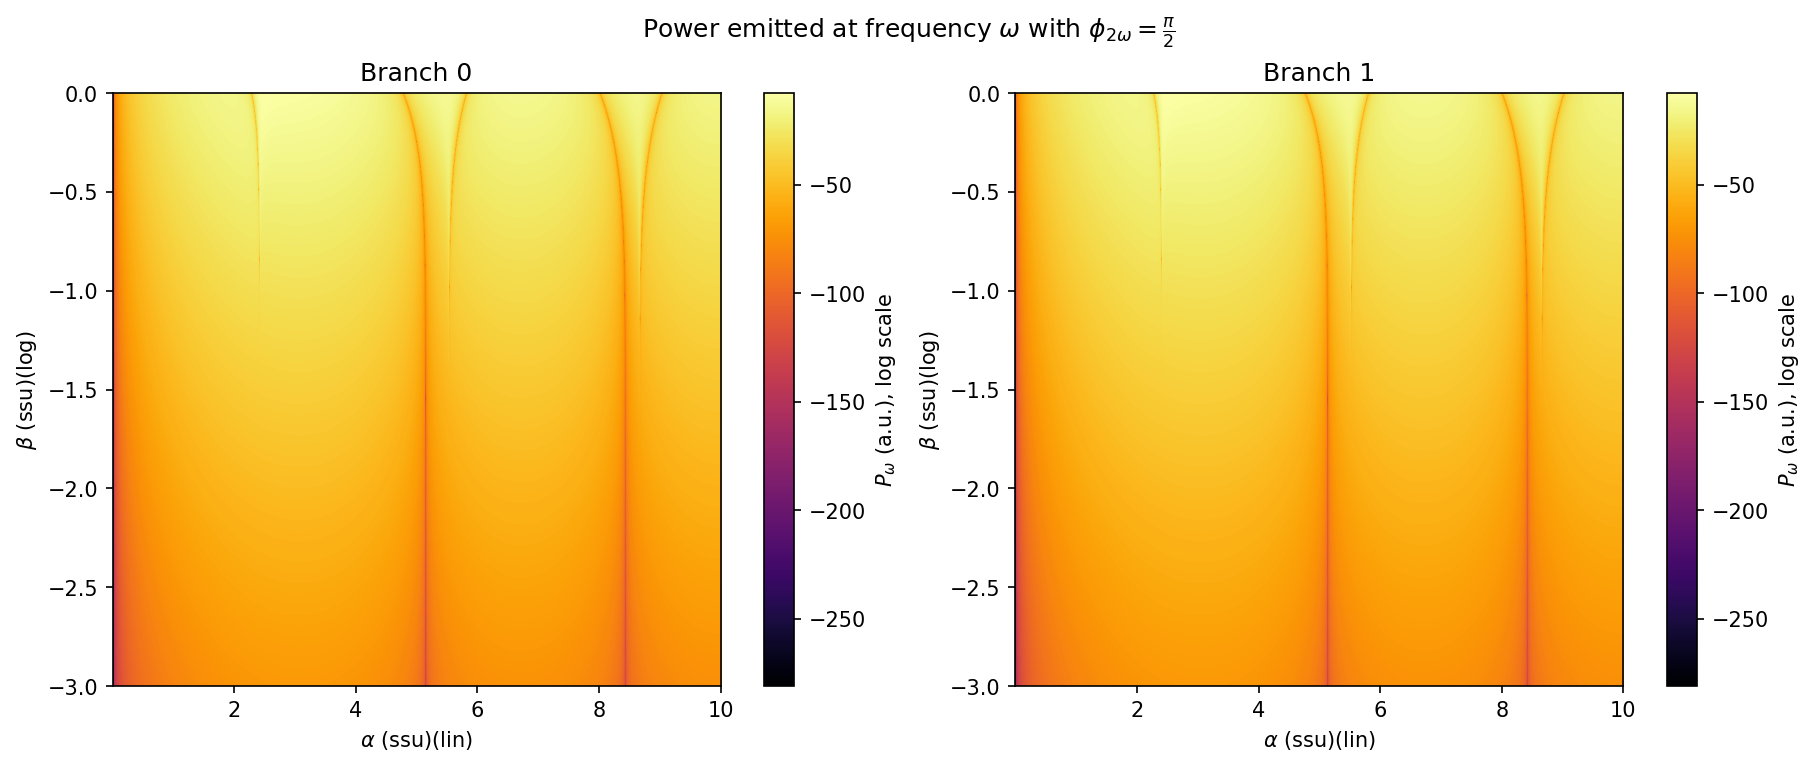

In [11]:
alpha_points = 1000
beta_points = 1000

USE_LOG_SCALING = [False, True]

if USE_LOG_SCALING[0] : # alpha log scaling 
    min_alpha = -1
    max_alpha = 1.4
    alphas = np.logspace(min_alpha, max_alpha, alpha_points)
else :                 # alpha lin scaling
    min_alpha = 1e-5
    max_alpha = 10
    alphas = np.linspace(min_alpha, max_alpha, alpha_points)

if USE_LOG_SCALING[1] : # beta log scaling
    min_beta = -3
    max_beta = -0
    betas = np.logspace(min_beta, max_beta, beta_points)
else :                  # beta lin scaling
    min_beta = 1e-5
    max_beta = 10
    betas = np.linspace(min_beta, max_beta, beta_points)

powers_branch_0 = np.zeros((alpha_points, beta_points))
powers_branch_1 = np.zeros((alpha_points, beta_points))

phis = [0, np.pi/2, 0]

for i, alpha in enumerate(alphas) : 
    for j, beta in enumerate(betas) : 
        powers_branch_0[i, j] = omega_harmonic_power([0, alpha, beta], phis, branch = 0, convolution_harmonics = 15)
        powers_branch_1[i, j] = omega_harmonic_power([0, alpha, beta], phis, branch = 1, convolution_harmonics = 15)
        

fig, ax = plt.subplots(1, 2, figsize = (12, 5), dpi = 150, constrained_layout = True)
ax_l, ax_r = ax

im_l = ax_l.imshow(10*np.log10(np.abs(powers_branch_0.T)), origin = 'lower', cmap = 'inferno', extent = [min_alpha, max_alpha, min_beta, max_beta], aspect = 'auto')
fig.colorbar(im_l, label = r'$P_{\omega}$ (a.u.), log scale', ax = ax_l)

ax_l.set_xlabel(r'$\alpha$ (ssu)' + f'{"(log)" if USE_LOG_SCALING[0] else "(lin)"}')
ax_l.set_ylabel(r'$\beta$ (ssu)' + f'{"(log)" if USE_LOG_SCALING[1] else "(lin)"}')
ax_l.set_title("Branch 0")

im_r = ax_r.imshow(10*np.log10(np.abs(powers_branch_1.T)), origin = 'lower', cmap = 'inferno', extent = [min_alpha, max_alpha, min_beta, max_beta], aspect = 'auto')
fig.colorbar(im_r, label = r'$P_{\omega}$ (a.u.), log scale', ax = ax_r)

ax_r.set_xlabel(r'$\alpha$ (ssu)' + f"{'(log)' if USE_LOG_SCALING[0] else '(lin)'}")
ax_r.set_ylabel(r'$\beta$ (ssu)' + f"{'(log)' if USE_LOG_SCALING[1] else '(lin)'}")
ax_r.set_title("Branch 1")

fig.suptitle(r"Power emitted at frequency $\omega$ with $\phi_{2\omega} = \frac{\pi}{2}$")

fig.savefig('map_2_0_log.png')


plt.show(fig)

#### ii. phases of $p_{-1}$ and $p_1$

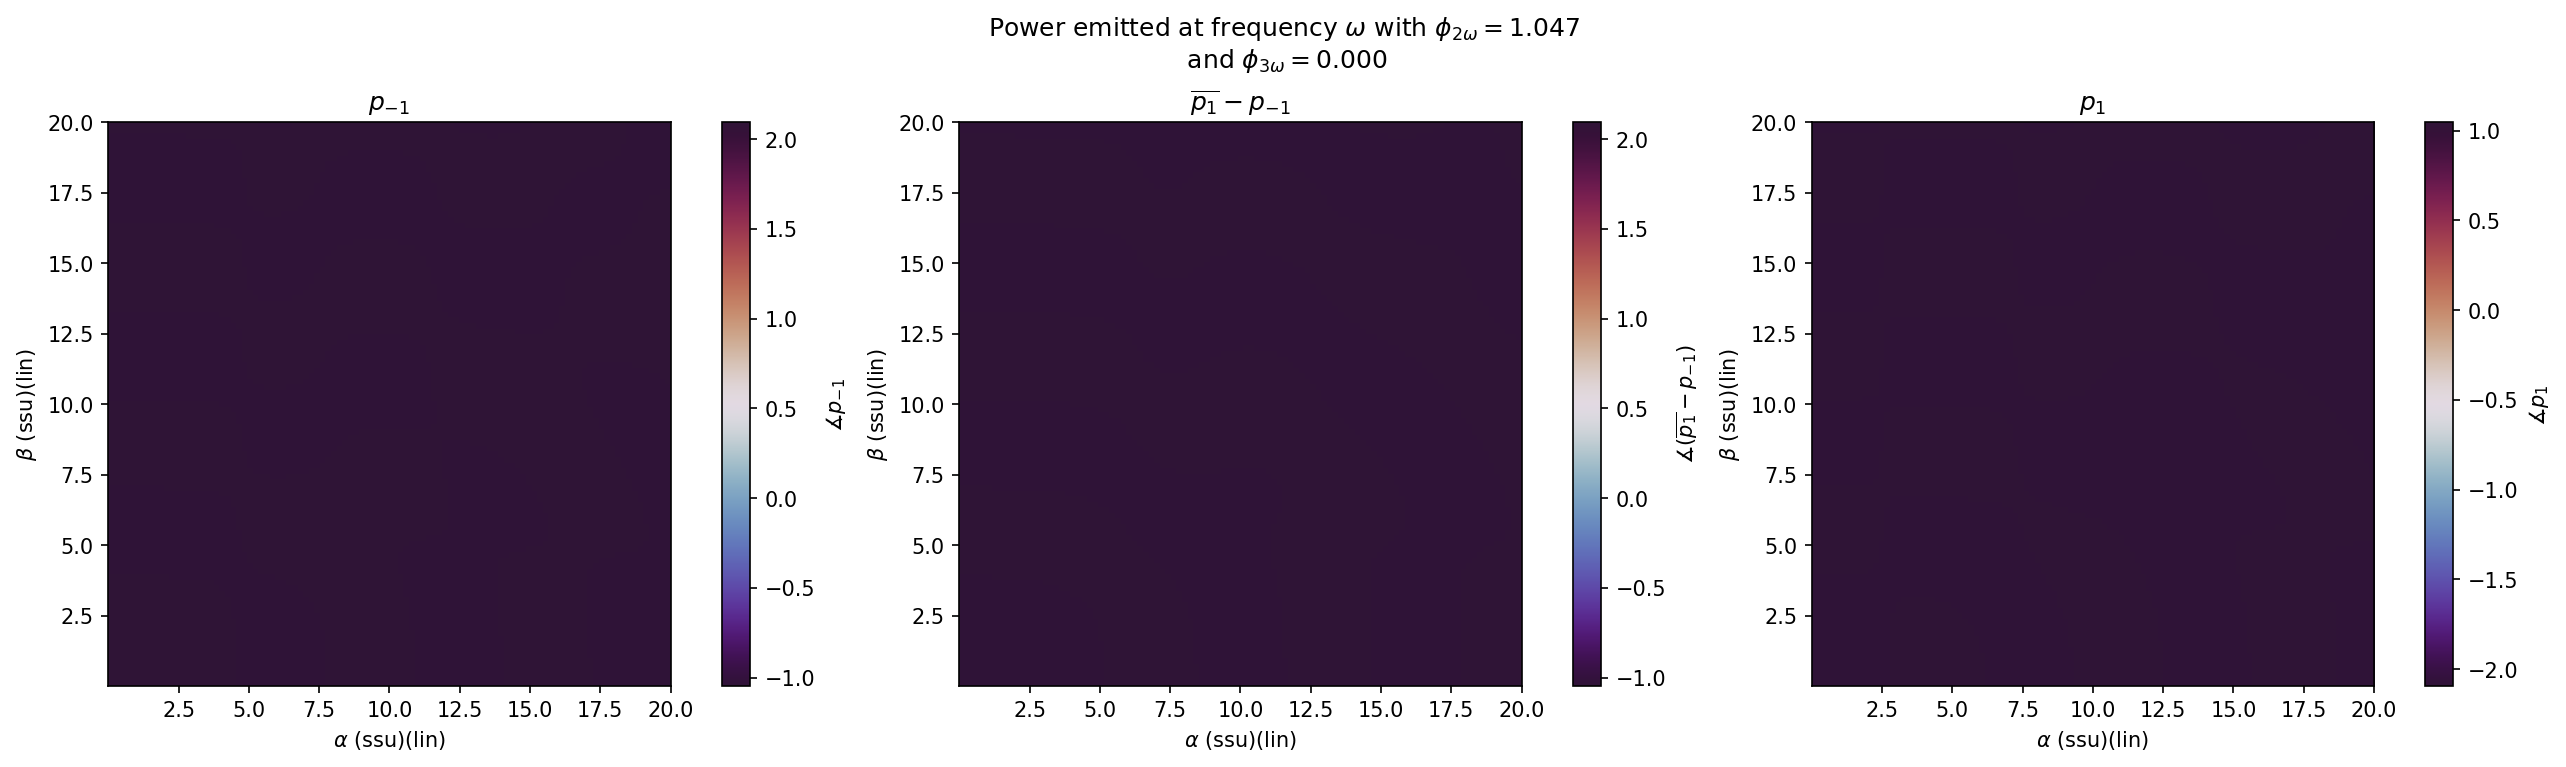

In [7]:
alpha_points = 101
beta_points = 101

max_l = 15
middle_index = max_l

USE_LOG_SCALING = [False, False]

if USE_LOG_SCALING[0] : # alpha log scaling 
    min_alpha = -1
    max_alpha = 1.4
    alphas = np.logspace(min_alpha, max_alpha, alpha_points)
else :                 # alpha lin scaling
    min_alpha = 1e-5
    max_alpha = 20
    alphas = np.linspace(min_alpha, max_alpha, alpha_points)

if USE_LOG_SCALING[1] : # beta log scaling
    min_beta = -3
    max_beta = -0
    betas = np.logspace(min_beta, max_beta, beta_points)
else :                  # beta lin scaling
    min_beta = 1e-5
    max_beta = 20
    betas = np.linspace(min_beta, max_beta, beta_points)

phases_pm1 = np.zeros((alpha_points, beta_points))
phases_p1 = np.zeros((alpha_points, beta_points))
phases_vna = np.zeros((alpha_points, beta_points))

phis = [0, np.pi/3, 0]

for i, alpha in enumerate(alphas) : 
    for j, beta in enumerate(betas) : 
        pl_values = pl([0, alpha, beta], phis, convolution_harmonics = 15, max_l = 15)
        pl_phases = np.angle(pl_values)
        phases_pm1[i, j] = pl_phases[middle_index - 1]
        phases_p1[i, j] = pl_phases[middle_index + 1]
        phases_vna[i, j] = np.angle(np.conj(pl_values[middle_index + 1]) - pl_values[middle_index - 1])
        

fig, ax = plt.subplots(1, 3, figsize = (17, 5), dpi = 150, constrained_layout = True)
ax_l, ax_m, ax_r = ax

im_l = ax_l.imshow(phases_pm1.T, origin = 'lower', cmap = 'twilight_shifted', extent = [min_alpha, max_alpha, min_beta, max_beta], aspect = 'auto')
fig.colorbar(im_l, label = r'$\measuredangle p_{-1}$', ax = ax_l)

ax_l.set_xlabel(r'$\alpha$ (ssu)' + f'{"(log)" if USE_LOG_SCALING[0] else "(lin)"}')
ax_l.set_ylabel(r'$\beta$ (ssu)' + f'{"(log)" if USE_LOG_SCALING[1] else "(lin)"}')
ax_l.set_title(r"$p_{-1}$")

im_r = ax_r.imshow(phases_p1.T, origin = 'lower', cmap = 'twilight_shifted', extent = [min_alpha, max_alpha, min_beta, max_beta], aspect = 'auto')
fig.colorbar(im_r, label = r'$\measuredangle p_{1}$', ax = ax_r)

ax_r.set_xlabel(r'$\alpha$ (ssu)' + f"{'(log)' if USE_LOG_SCALING[0] else '(lin)'}")
ax_r.set_ylabel(r'$\beta$ (ssu)' + f"{'(log)' if USE_LOG_SCALING[1] else '(lin)'}")
ax_r.set_title(r"$p_1$")

im_m = ax_m.imshow(phases_vna.T, origin = 'lower', cmap = 'twilight_shifted', extent = [min_alpha, max_alpha, min_beta, max_beta], aspect = 'auto')
fig.colorbar(im_m, label = r'$\measuredangle (\overline{p_{1}} - p_{-1})$', ax = ax_m)

ax_m.set_xlabel(r'$\alpha$ (ssu)' + f"{'(log)' if USE_LOG_SCALING[0] else '(lin)'}")
ax_m.set_ylabel(r'$\beta$ (ssu)' + f"{'(log)' if USE_LOG_SCALING[1] else '(lin)'}")
ax_m.set_title(r"$\overline{p_{1}} - p_{-1}$")

fig.suptitle(r"Power emitted at frequency $\omega$ with $\phi_{2\omega} =$" f"{phis[1]:.3f}\n" r" and $\phi_{3\omega} = $" f"{phis[2]:.3f}")

fig.savefig('map_phases_3_0.png')


plt.show(fig)

### 2. Evolution of complex coefficients $p_{-1}$ and $p_1$ with phase sweeps

Text(0.5, 0.98, '$\\alpha = 6.09$, $\\beta = 8.54$  $\\varphi_{2\\omega} = \\varphi + $0.52, $\\varphi_{3\\omega} = \\frac{3}{2}\\varphi + $0.00, ')

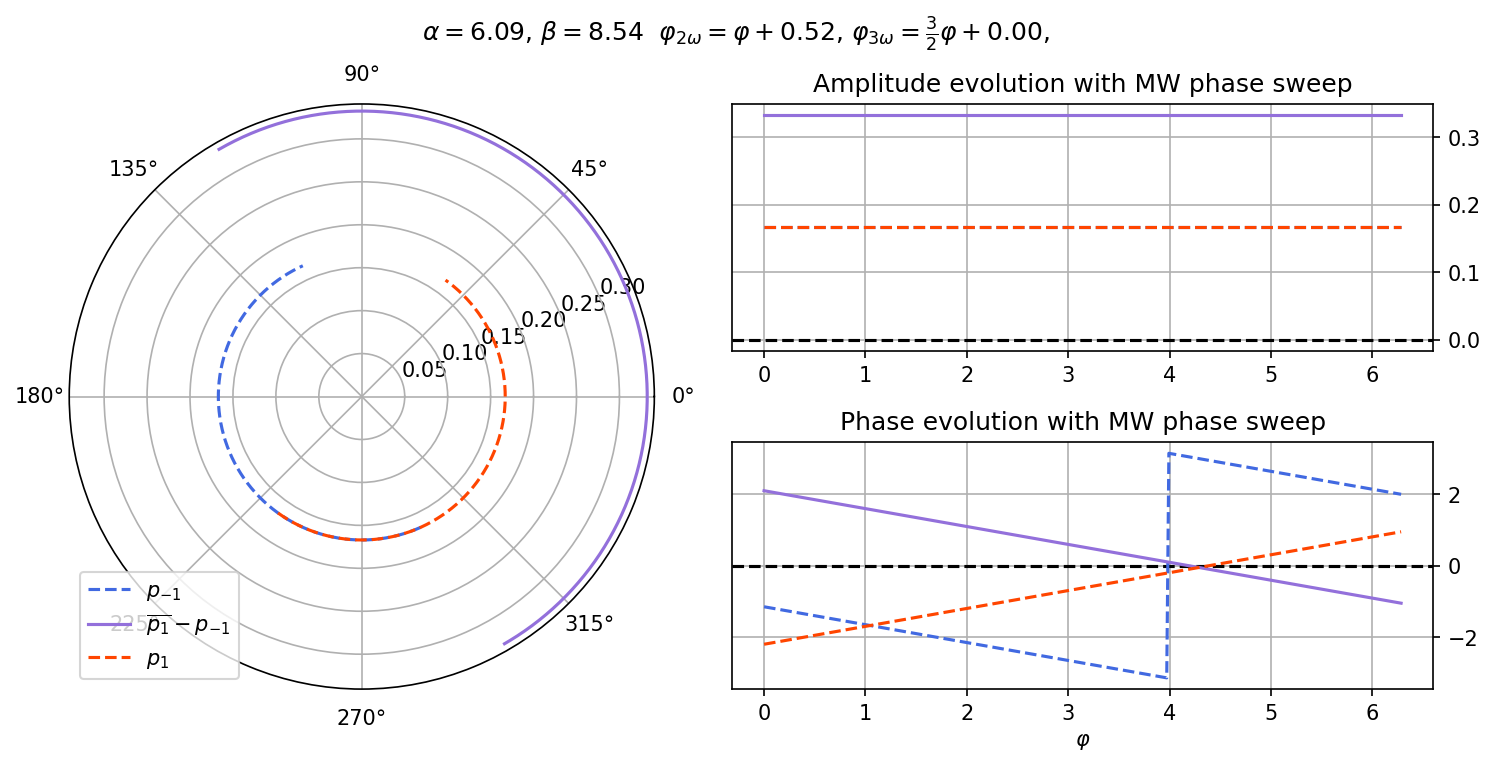

In [23]:
FOLLOW_PHASE_CONSTRAINT = True
SWEEP_OMEGA_2 = True
SWEEP_OMEGA_3 = not(SWEEP_OMEGA_2)
omega_3_offset = 0
omega_2_offset = np.pi/6
phase_points = 300

alpha = 6.08636 #2.63# 6.08636
beta =  8.54 #3.83171

phases = np.linspace(0, 2*np.pi, phase_points)

if FOLLOW_PHASE_CONSTRAINT : 
    phase_lists = np.array([[0, phase + omega_2_offset, 3*phase/2  + omega_3_offset] for phase in phases])
    title_string = r"$\varphi_{2\omega} = \varphi + $" f"{omega_2_offset:.2f}, " r"$\varphi_{3\omega} = \frac{3}{2}\varphi + $" f"{omega_3_offset:.2f}, "
elif SWEEP_OMEGA_2 : 
    phase_lists = np.array([[0, phase + omega_2_offset, omega_3_offset] for phase in phases])
    title_string = r"$\varphi_{2\omega} = \varphi + $" f"{omega_2_offset:.2f}, " r"$\varphi_{3\omega} = $" f"{omega_3_offset:.2f}, "
else : 
    phase_lists = np.array([[0, omega_2_offset, phase + omega_3_offset] for phase in phases])
    title_string = r"$\varphi_{2\omega} = $" f"{omega_2_offset:.2f}, " r"$\varphi_{3\omega} = \varphi + $" f"{omega_3_offset:.2f}, "


vna_values = np.zeros_like(phases, dtype = "complex")
pm1_values = np.zeros_like(phases, dtype = "complex")

for i, phase_list in enumerate(phase_lists):
    pls = pl([0, alpha, beta], phase_list, max_l = 5)
    n = len(pls)
    p = (n - 1)//2
    pm1_values[i] = pls[p + 1]
    vna_values[i] = pls[p -1]

fig = plt.figure(dpi = 150, figsize  = (10, 5), constrained_layout = True)
gs = fig.add_gridspec(2, 2)

ax_l = fig.add_subplot(gs[:, 0], projection = 'polar')
ax_br = fig.add_subplot(gs[1, 1])
ax_tr = fig.add_subplot(gs[0, 1], sharex = ax_br)

ax_tr.axhline(color = 'k', ls = '--')
ax_br.axhline(color = 'k', ls = '--')


labels = [ r"$p_{-1} + p_1$", r'$p_{-1}$', r"$\overline{p_{1}} - p_{-1}$",r'$p_1$']
colors = ["orange","royalblue", "mediumpurple", "orangered"]
linestyles = [":","--","-","--"]
show = [False, True, True, True] # allows you to show / hide different stuff

for i, trace in enumerate([pm1_values + vna_values,pm1_values, np.conj(vna_values) - pm1_values, vna_values]):
    r = np.absolute(trace)
    theta = np.angle(trace)
    
    #if i == 0 : 
    #    ax.plot(theta, r, label = labels[i])
    if show[i]:
        ax_l.plot(theta, r, label = labels[i], color = colors[i], ls = linestyles[i])
        ax_tr.plot(phases, r, color = colors[i], ls = linestyles[i])
        ax_br.plot(phases, theta, color = colors[i], ls = linestyles[i])

ax_l.grid(True)
ax_l.legend()

ax_tr.grid(True)
ax_tr.set_title("Amplitude evolution with MW phase sweep")
ax_tr.yaxis.tick_right()
ax_tr.yaxis.set_ticks_position('right')

ax_br.set_title("Phase evolution with MW phase sweep")
ax_br.set_xlabel(r"$\varphi$")
ax_br.grid(True)
ax_br.yaxis.tick_right()
ax_br.yaxis.set_ticks_position('right')

fig.suptitle(fr"$\alpha = {alpha:.2f}$, $\beta = {beta:.2f}$  " + title_string )

### 3. TODO : Using power map to do calibs

In [ ]:
big_harmonic_points = 1000
small_harmonic_points = 50

big_harmonic_values = np.linspace(1e-5, 20, big_harmonic_points)
small_harmonic_values = np.linspace(1e-5, 1, small_harmonic_points)

powers = np.zeros((big_harmonic_points, small_harmonic_points))

for i, alpha in enumerate(big_harmonic_values) : 
    for j, beta in enumerate(small_harmonic_values) : 
        powers[i, j] = omega_harmonic_power([0, alpha, beta], [0, np.pi/3, 0], convolution_harmonics = 15)
        

fig, ax = plt.subplots(dpi = 150, constrained_layout = True)

im = ax.imshow(10*np.log10(np.abs(powers.T)), origin = 'lower', cmap = 'inferno', extent = [big_harmonic_values[0], big_harmonic_values[-1], small_harmonic_values[0], small_harmonic_values[-1]])
fig.colorbar(im, label = r'$P_{\omega}$ (a.u.), log scale')
ax.set_xlabel(r'$\alpha$ (ssu)')
ax.set_ylabel(r'$\beta$ (ssu)')
ax.set_title(r"Power emitted at frequency $\omega$ with $\phi_{2\omega} = \frac{\pi}{3}$")

fig.savefig('map_3_0.png')

plt.show(fig)

### 4. Studying zero-current phase $\mathrm{Arg}(p_0)$
#### i. Studying phase dependence

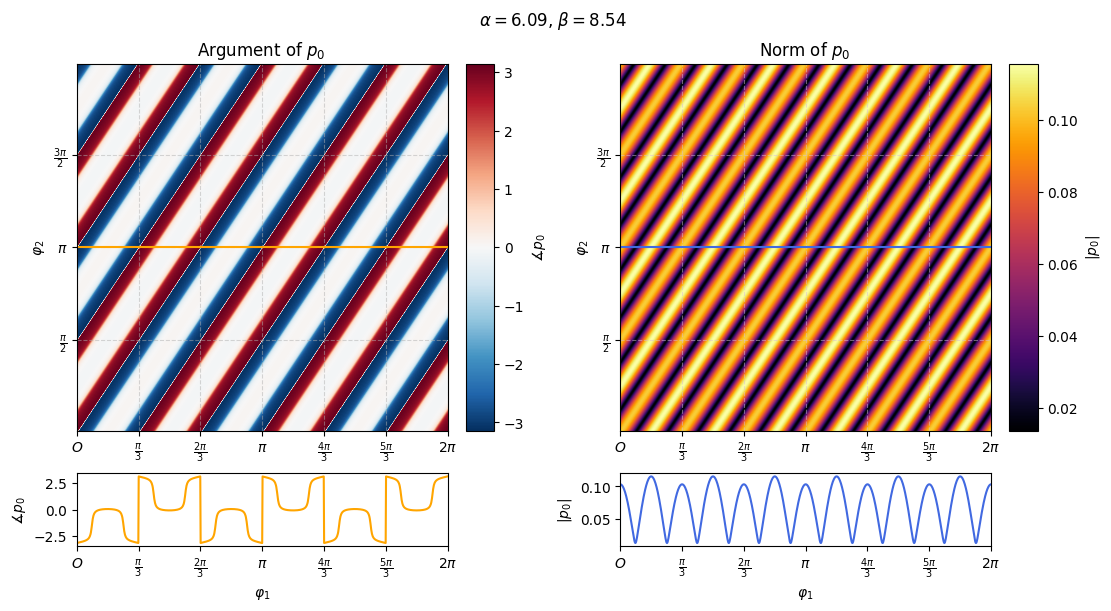

In [8]:
MAJOR_TICKS_VALUES_Y = np.linspace(0, 2*np.pi, 5)
MINOR_TICKS_VALUES_Y = np.linspace(0, 2*np.pi, 9)

MAJOR_TICKS_LABELS_Y = [r"$O$",r"$\frac{\pi}{2}$",r"$\pi}$",r"$\frac{3\pi}{2}$",r"$2\pi$",]

MAJOR_TICKS_VALUES_X = np.linspace(0, 2*np.pi, 7)
MINOR_TICKS_VALUES_X = np.linspace(0, 2*np.pi, 13)

MAJOR_TICKS_LABELS_X = [r"$O$",r"$\frac{\pi}{3}$",r"$\frac{2\pi}{3}$",r"$\pi}$",r"$\frac{4\pi}{3}$",r"$\frac{5\pi}{3}$",r"$2\pi$",]

phase_points = 1001 # must be odd
center_value = (phase_points - 1)//2


# J2 = J1 : x ≈ 2.62987, x ≈ 6.08636, x ≈ 9.29899 (values for alpha for PM)
# max of J1 : x≈1.84118 better than x≈8.53632

alphas = [0, 6.08636, 8.53632]

phase_values = np.linspace(0, 2*np.pi, phase_points)
p0_values = np.zeros((phase_points, phase_points), dtype = "complex")

n_harmonics = 15
index_center = n_harmonics

for i, phi_1 in enumerate(phase_values):
    for j, phi_2 in enumerate(phase_values):
        p_values = pl(alphas, [0, phi_1, phi_2], convolution_harmonics = n_harmonics, max_l = n_harmonics)
        p0_values[i, j]  = p_values[index_center]
    

p0_angles, p0_norms = np.angle(p0_values), np.abs(p0_values)

max_arg = np.max(np.abs(p0_angles))

fig = plt.figure(figsize =(11, 6), dpi = 100, constrained_layout = True)
gs = fig.add_gridspec(2, 4, width_ratios = [13, 1, 13, 1], height_ratios = [5, 1])

ax_l = fig.add_subplot(gs[0, 0])
ax_cb_l = fig.add_subplot(gs[0, 1])
ax_r = fig.add_subplot(gs[0, 2])
ax_cb_r = fig.add_subplot(gs[0, -1])
ax_slice_phase = fig.add_subplot(gs[-1, 0], sharex = ax_l) 
ax_slice_norm = fig.add_subplot(gs[-1, 2], sharex = ax_r)

for axis in [ax_l, ax_r]:
    axis.set_xlim(0, 2*np.pi)
    axis.set_ylim(0, 2*np.pi)
    axis.set_xticks(MAJOR_TICKS_VALUES_X, labels = MAJOR_TICKS_LABELS_X)
    axis.set_yticks(MAJOR_TICKS_VALUES_Y, labels = MAJOR_TICKS_LABELS_Y)

for axis in [ax_slice_phase, ax_slice_norm]:
    axis.set_xlim(0, 2*np.pi)
    axis.set_xticks(MAJOR_TICKS_VALUES_X, labels = MAJOR_TICKS_LABELS_X)

# TOP LEFT PLOT
im_l = ax_l.imshow(p0_angles.T, origin = 'lower', cmap = 'RdBu_r', extent = [0, 2*np.pi, 0, 2*np.pi], vmin = -max_arg, vmax = max_arg, aspect = 'auto')
fig.colorbar(im_l, label = r'$\measuredangle p_0$', cax = ax_cb_l)

ax_l.plot(phase_values, phase_values[center_value]*np.ones_like(phase_values), color = 'orange')

#ax_l.set_xlabel(r'$\varphi_1$' )
ax_l.set_ylabel(r'$\varphi_2$')
ax_l.set_title(r"Argument of $p_0$ ")
ax_l.axis('equal')
ax_l.grid(True, alpha = 0.5, ls = '--')

# TOP RIGHT PLOT
im_r = ax_r.imshow(p0_norms.T, origin = 'lower', cmap = 'inferno', extent = [0, 2*np.pi, 0, 2*np.pi])
cb = fig.colorbar(im_r, label = r'$\left| p_0 \right|$', cax = ax_cb_r)
cb.ax.yaxis.set_offset_position('left')
cb.update_ticks()

ax_r.plot(phase_values, phase_values[center_value]*np.ones_like(phase_values), color = 'royalblue')

#ax_r.set_xlabel(r'$\varphi_1$' )
ax_r.set_ylabel(r'$\varphi_2$')
ax_r.set_title(r"Norm of $p_0$ ")
ax_r.axis('equal')
ax_r.grid(True, alpha = 0.5, ls = '--', color = 'thistle')

# PHASE SLICE PLOT

ax_slice_phase.plot(phase_values, p0_angles[:, center_value], color = 'orange')
ax_slice_phase.set_xlabel(r'$\varphi_1$' )
ax_slice_phase.set_ylabel(r'$\measuredangle p_0$' )

# NORM SLICE PLOT

ax_slice_norm.plot(phase_values, p0_norms[:, center_value], color = 'royalblue')
ax_slice_norm.set_xlabel(r'$\varphi_1$' )
ax_slice_norm.set_ylabel(r'$\left| p_0 \right|$' )

fig.suptitle(fr"$\alpha = {alphas[1]:.2f}$, $\beta = {alphas[2]:.2f}$  ")
#fig.savefig("p0_opt_3.png")
plt.show(fig)

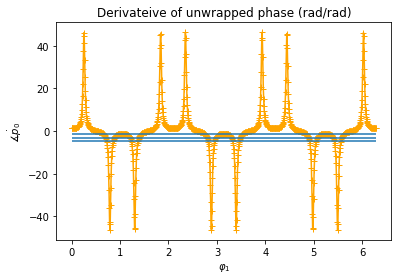

In [10]:
fig_1, ax_1 = plt.subplots()
ax_1.plot(phase_values, np.gradient(np.unwrap(p0_angles[:, center_value]), phase_values[1] - phase_values[0]), color = 'orange', marker='+')
ax_1.hlines([-3*np.pi/2, -np.pi, -np.pi/2], 0, 2*np.pi)
ax_1.set_xlabel(r'$\varphi_1$' )
ax_1.set_ylabel(r'$\dot{\measuredangle p_0}$' )
ax_1.set_title("Derivateive of unwrapped phase (rad/rad)")
fig_1.savefig("unwrapped_p0_opt_3.png")

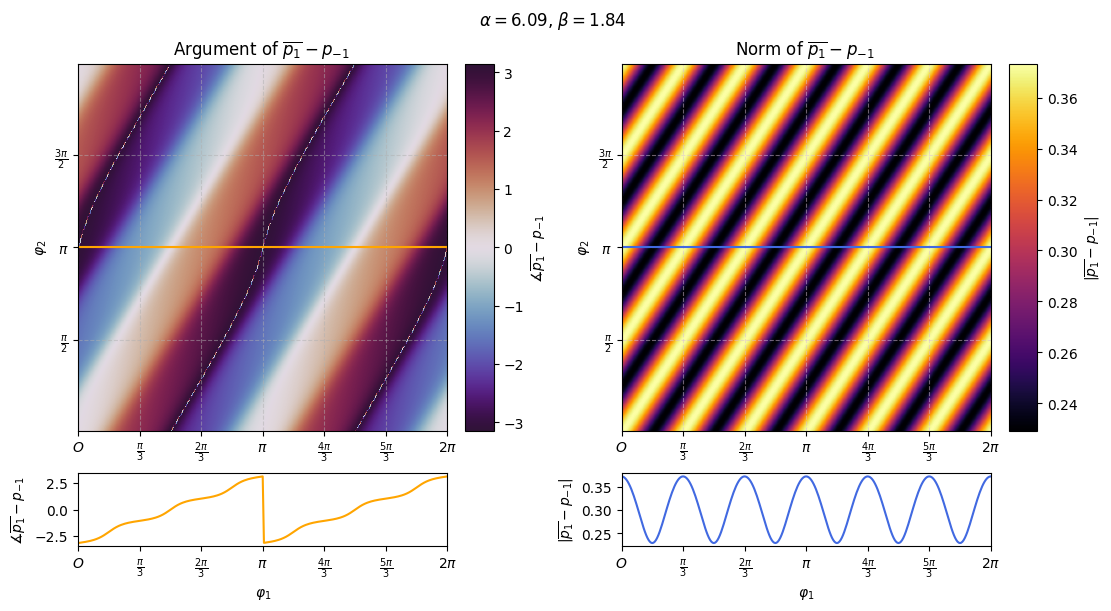

In [19]:
MAJOR_TICKS_VALUES_Y = np.linspace(0, 2*np.pi, 5)
MINOR_TICKS_VALUES_Y = np.linspace(0, 2*np.pi, 9)

MAJOR_TICKS_LABELS_Y = [r"$O$",r"$\frac{\pi}{2}$",r"$\pi}$",r"$\frac{3\pi}{2}$",r"$2\pi$",]

MAJOR_TICKS_VALUES_X = np.linspace(0, 2*np.pi, 7)
MINOR_TICKS_VALUES_X = np.linspace(0, 2*np.pi, 13)

MAJOR_TICKS_LABELS_X = [r"$O$",r"$\frac{\pi}{3}$",r"$\frac{2\pi}{3}$",r"$\pi}$",r"$\frac{4\pi}{3}$",r"$\frac{5\pi}{3}$",r"$2\pi$",]

phase_points = 301 # must be odd
center_value = (phase_points - 1)//2


# J2 = J1 : x ≈ 2.62987, x ≈ 6.08636, x ≈ 9.29899 (values for alpha for PM)
# max of J1 : x≈1.84118 better than x≈8.53632

alphas = [0, 6.08636, 1.84118]

phase_values = np.linspace(0, 2*np.pi, phase_points)
vna_values = np.zeros((phase_points, phase_points), dtype = "complex")

n_harmonics = 15
index_center = n_harmonics

for i, phi_1 in enumerate(phase_values):
    for j, phi_2 in enumerate(phase_values):
        p_values = pl(alphas, [0, phi_1, phi_2], convolution_harmonics = n_harmonics, max_l = n_harmonics)
        vna_values[i, j]  = np.conj(p_values[index_center + 1]) - p_values[index_center - 1]
    

p1_angles, p1_norms = np.angle(vna_values), np.abs(vna_values)

max_arg = np.max(np.abs(p1_angles))

fig = plt.figure(figsize =(11, 6), dpi = 100, constrained_layout = True)
gs = fig.add_gridspec(2, 4, width_ratios = [13, 1, 13, 1], height_ratios = [5, 1])

ax_l = fig.add_subplot(gs[0, 0])
ax_cb_l = fig.add_subplot(gs[0, 1])
ax_r = fig.add_subplot(gs[0, 2])
ax_cb_r = fig.add_subplot(gs[0, -1])
ax_slice_phase = fig.add_subplot(gs[-1, 0], sharex = ax_l) 
ax_slice_norm = fig.add_subplot(gs[-1, 2], sharex = ax_r)

for axis in [ax_l, ax_r]:
    axis.set_xlim(0, 2*np.pi)
    axis.set_ylim(0, 2*np.pi)
    axis.set_xticks(MAJOR_TICKS_VALUES_X, labels = MAJOR_TICKS_LABELS_X)
    axis.set_yticks(MAJOR_TICKS_VALUES_Y, labels = MAJOR_TICKS_LABELS_Y)

for axis in [ax_slice_phase, ax_slice_norm]:
    axis.set_xlim(0, 2*np.pi)
    axis.set_xticks(MAJOR_TICKS_VALUES_X, labels = MAJOR_TICKS_LABELS_X)

# TOP LEFT PLOT
im_l = ax_l.imshow(p1_angles.T, origin = 'lower', cmap = 'twilight_shifted', extent = [0, 2*np.pi, 0, 2*np.pi], vmin = -max_arg, vmax = max_arg, aspect = 'auto')
fig.colorbar(im_l, label = r'$\measuredangle \overline{p_1} - p_{-1}$', cax = ax_cb_l)

ax_l.plot(phase_values, phase_values[center_value]*np.ones_like(phase_values), color = 'orange')

#ax_l.set_xlabel(r'$\varphi_1$' )
ax_l.set_ylabel(r'$\varphi_2$')
ax_l.set_title(r"Argument of $\overline{p_1} - p_{-1}$ ")
ax_l.axis('equal')
ax_l.grid(True, alpha = 0.5, ls = '--')

# TOP RIGHT PLOT
im_r = ax_r.imshow(p1_norms.T, origin = 'lower', cmap = 'inferno', extent = [0, 2*np.pi, 0, 2*np.pi])
cb = fig.colorbar(im_r, label = r'$\left| \overline{p_1} - p_{-1} \right|$', cax = ax_cb_r)
cb.ax.yaxis.set_offset_position('left')
cb.update_ticks()

ax_r.plot(phase_values, phase_values[center_value]*np.ones_like(phase_values), color = 'royalblue')

#ax_r.set_xlabel(r'$\varphi_1$' )
ax_r.set_ylabel(r'$\varphi_2$')
ax_r.set_title(r"Norm of $\overline{p_1} - p_{-1}$ ")
ax_r.axis('equal')
ax_r.grid(True, alpha = 0.5, ls = '--', color = 'thistle')

# PHASE SLICE PLOT

ax_slice_phase.plot(phase_values, p1_angles[:, center_value], color = 'orange')
ax_slice_phase.set_xlabel(r'$\varphi_1$' )
ax_slice_phase.set_ylabel(r'$\measuredangle \overline{p_1} - p_{-1}$' )

# NORM SLICE PLOT

ax_slice_norm.plot(phase_values, p1_norms[:, center_value], color = 'royalblue')
ax_slice_norm.set_xlabel(r'$\varphi_1$' )
ax_slice_norm.set_ylabel(r'$\left| \overline{p_1} - p_{-1} \right|$' )

fig.suptitle(fr"$\alpha = {alphas[1]:.2f}$, $\beta = {alphas[2]:.2f}$  ")
fig.savefig("vna_opt10.png")
plt.show(fig)